# Data Preparing

In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2

In [2]:
data_dir = '../dataset/township_alphabet_data'
image_size = (64, 64)  # Adjust the image size

def load_and_process(data_dir):
    data = []  # To store image data
    labels = []  # To store corresponding labels
    for folder in os.listdir(data_dir):
        label = folder.split('_')[0]  # Use the folder name as the label (0, 1, ..., 27)
        folder_path = os.path.join(data_dir, folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = tf.keras.utils.load_img(img_path) # load image
            img = tf.image.rgb_to_grayscale(img) # convert 3-D to 1-D grayscale
            img = tf.image.resize(img, size=image_size, method='area') # resize image to (64, 64)
            img = 255 - img
            data.append(img)
            labels.append(int(label))
    return data, labels

data, labels = load_and_process(data_dir)
data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.uint8)[:, np.newaxis]

In [3]:
print("Data shape:", data.shape)
print("Label shape", labels.shape)

Data shape: (6215, 64, 64, 1)
Label shape (6215, 1)


# Visualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
idx2word = {}

for folder in os.listdir(data_dir):
    key, value = folder.split('_')
    idx2word[int(key)] = value

In [36]:
# Sort the dictionary by keys in ascending order
sorted_items = sorted(idx2word.items())
sorted_dict = {k: v for k, v in sorted_items}
sorted_dict

{0: 'ka',
 1: 'kha',
 2: 'gaNge',
 3: 'gaGyi',
 4: 'nga',
 5: 'saLone',
 6: 'saLane',
 7: 'zaGwe',
 8: 'Nya',
 9: 'naKyi',
 10: 'taWanPu',
 11: 'htaSinHtoo',
 12: 'daDwe',
 13: 'daOkeChait',
 14: 'ngaNge',
 15: 'Pa',
 16: 'pha',
 17: 'baHtetChait',
 18: 'baGone',
 19: 'ma',
 20: 'yaPalet',
 21: 'yaGout',
 22: 'La',
 23: 'wa',
 24: 'tha',
 25: 'ha',
 26: 'ah',
 27: 'Ou'}

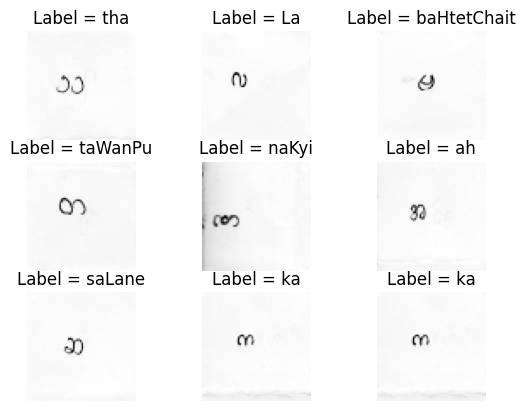

In [6]:
def show_images(x, y, title_str='Label'):
    for c in range(1, 10):
        plt.subplot(3, 3, c)
        i = np.random.randint(len(x)) # Generate random integer number
        im = x[i] # get i-th image
        plt.axis("off")
        index = int(y[i]) # get i-th label
        label = idx2word.get(index)
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap="Greys")
show_images(data, labels)

# Data Preprocessing

In [7]:
# Labels
label = np.unique(labels)
num_classes = len(label)
print("Number of classes:", num_classes)
print("Unique Labels:", label)

Number of classes: 28
Unique Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [8]:
# Create a data augmentation stage with rotations, zooms
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.1), # Adding random rotation by 10 %
        tf.keras.layers.RandomZoom(0.1), # Adding random zoom by 10 %
        tf.keras.layers.RandomBrightness(0.1),  # Adding brightness adjustment
        tf.keras.layers.GaussianNoise(0.01),  # Adding random noise (adjust the scale as needed)
    ]
)

In [9]:
# Create tensorflow Dataset object to represents a potentially large set of elements
dataset = tf.data.Dataset.from_tensor_slices((data, labels))

# shuffle the dataset
dataset = dataset.shuffle(data.shape[0], reshuffle_each_iteration=False)

batch_size = 32

# get training, validation and testing dataset
data_test = dataset.take(1000).batch(batch_size) # take the first 1000 images from dataset
data_valid = dataset.skip(1000).take(1000).batch(batch_size) # take the second 1000 images from dataset
data_train = dataset.skip(2000).batch(batch_size).map(lambda x, y: (data_augmentation(x), y)) # take the rest and apply augmentation

In [10]:
# Custom preprocessing layer with Normalization
class CustomPreprocessNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomPreprocessNormalizationLayer, self).__init__()

    def call(self, inputs):
        # Normalize pixel values to [0, 1]
        normalized_images = inputs / 255.0

        return normalized_images

# Building the model

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [12]:
def create_model():
    # Define the CNN model
    model = tf.keras.models.Sequential()

    # Add the CustomPreprocessNormalizationLayer as the first layer
    model.add(CustomPreprocessNormalizationLayer())

    ### Add Convolutional and MaxPooling layers

    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(32, 3, activation='relu',input_shape=(64, 64, 1)))
    model.add(MaxPooling2D((2, 2)))

    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # CONV => RELU => MAX-POOLING
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output for Dense layers
    model.add(Flatten())

    # Add Dense layers
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.2)) # Dropout layer with a dropout rate of 0.2

    # Add output layer with 28 Neurons
    model.add(Dense(num_classes,activation='softmax'))

    return model

In [13]:
model = create_model()
model.build(input_shape=(None, 64, 64, 1)) # late variable creation
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_preprocess_normaliza  (None, 64, 64, 1)        0         
 tion_layer (CustomPreproces                                     
 sNormalizationLayer)                                            
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                  

In [14]:
# Configures the model for training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# use TensorBoard, princess Aurora!
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [16]:
# Train the model
epoch = 80
history = model.fit(data_train,
                    epochs=epoch,
                    validation_data=data_valid,
                    callbacks=callbacks
                   )

Epoch 1/80
132/132 [==============================] - 14s 23ms/step - loss: 3.3334 - accuracy: 0.0304 - val_loss: 3.3324 - val_accuracy: 0.0400
Epoch 2/80
132/132 [==============================] - 2s 14ms/step - loss: 3.3207 - accuracy: 0.0451 - val_loss: 3.1871 - val_accuracy: 0.0940
Epoch 3/80
132/132 [==============================] - 3s 25ms/step - loss: 2.8078 - accuracy: 0.1262 - val_loss: 2.5778 - val_accuracy: 0.1790
Epoch 4/80
132/132 [==============================] - 2s 15ms/step - loss: 2.4211 - accuracy: 0.2183 - val_loss: 2.0729 - val_accuracy: 0.2990
Epoch 5/80
132/132 [==============================] - 2s 15ms/step - loss: 2.1235 - accuracy: 0.3032 - val_loss: 1.8655 - val_accuracy: 0.3520
Epoch 6/80
132/132 [==============================] - 2s 15ms/step - loss: 1.8675 - accuracy: 0.3827 - val_loss: 1.4103 - val_accuracy: 0.4730
Epoch 7/80
132/132 [==============================] - 2s 15ms/step - loss: 1.5795 - accuracy: 0.4586 - val_loss: 1.1598 - val_accuracy: 0.588

In [17]:
test_loss, test_acc = model.evaluate(data_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

32/32 [==============================] - 0s 4ms/step - loss: 0.3035 - accuracy: 0.9410
Test accuracy: 94.10%


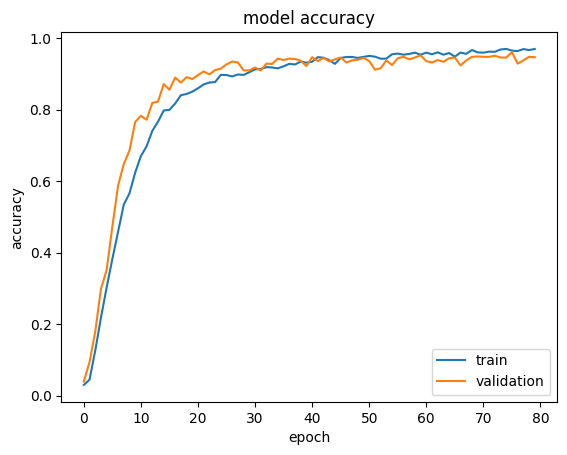

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='lower right')
plt.show()

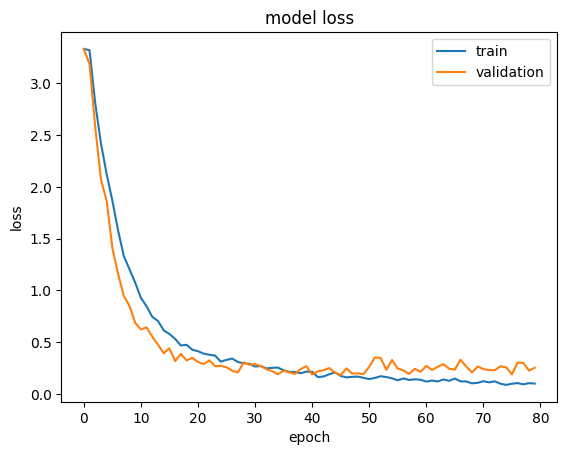

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train','validation'],loc='upper right')
plt.show()

1/1 [==============================] - 0s 19ms/step


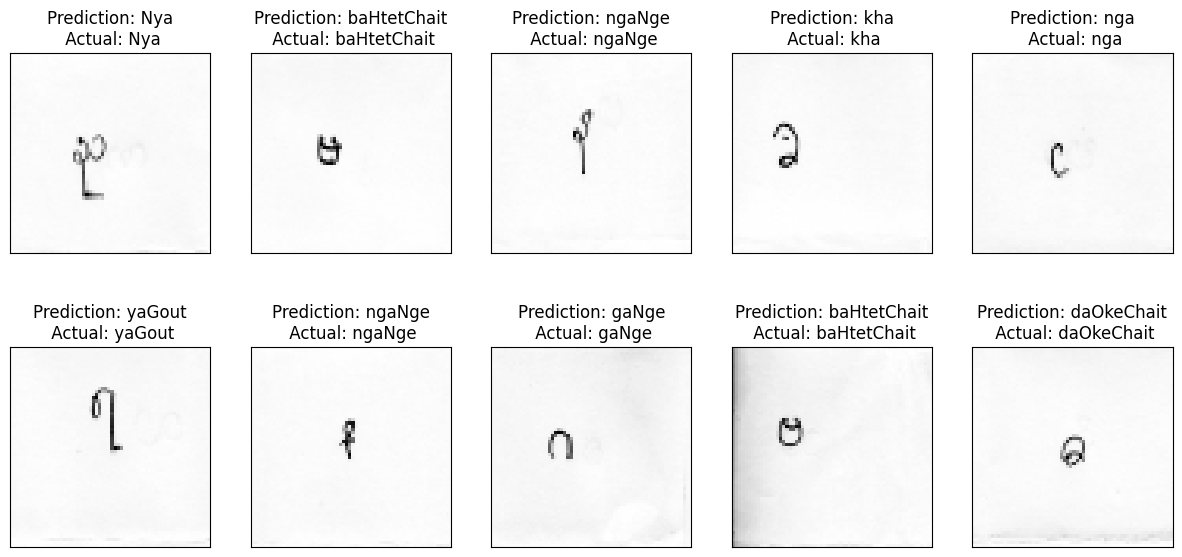

In [33]:
# Generate a random number between 11 and 990
random_number = np.random.randint(11, 991)
ds = data_test.unbatch().skip(random_number).take(10)

fig = plt.figure(figsize=(15, 7))
for j, (example, label) in enumerate(ds):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example.numpy(), cmap="Greys")
    pred = model.predict(tf.expand_dims(example, axis=0)) # prediction probs
    ans = idx2word[np.argmax(pred)] # convert prediction index to word
    actual = idx2word[int(label)] # actual label
    ax.set_title("Prediction: "+ ans +
                 "\n Actual: "+ actual)

plt.show()

# Testing a real-world image

In [21]:
image_path = "../images/taWanPu.png"
image = tf.keras.preprocessing.image.load_img(image_path) # load image
image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) # convert to Grayscale
image = cv2.resize(image, (30, 30), interpolation=cv2.INTER_LINEAR) # rescale the image
# Apply thresholding to remove noise and enhance contrast
threshold_value = 140  # Adjust this threshold as needed
_, image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY) # apply threshold to each pixels

In [22]:
image = tf.cast(image, tf.float32) # cast pixel values to float
image = 255 - np.array(image)
np.array(image).shape

(30, 30, 1)

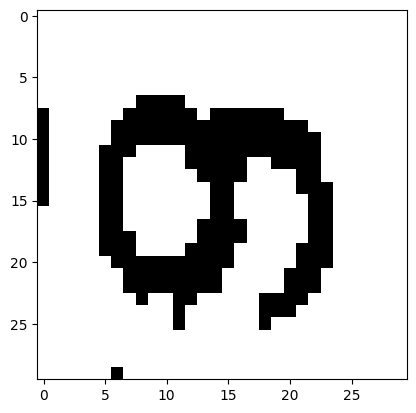

In [23]:
plt.imshow(image, cmap="Greys")

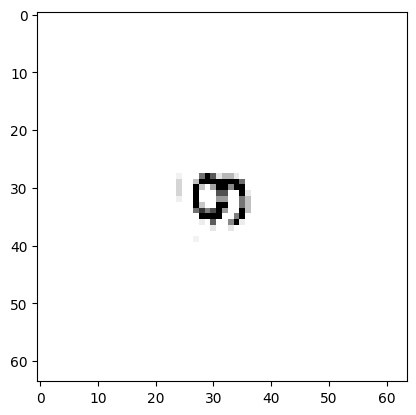

In [24]:
# Apply padding to the image to create a border, and then resize it to 64x64 pixels.
import cv2
import numpy as np

# Define the padding values (top, bottom, left, right)
top = 50
bottom = 50
left = 50
right = 50

# Define the padding color (white)
padding_color = [0, 0, 0]

# Add padding to the image
image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR) # rescale the image
plt.imshow(image, cmap="Greys")

In [25]:
image = tf.expand_dims(image, axis=0) # add dims to the first axis
img_input = tf.expand_dims(image, axis=-1) # add dims to the first axis
img_input.shape

TensorShape([1, 64, 64, 1])

In [26]:
y_input_pred = model.predict(img_input)
print(idx2word.get(np.argmax(y_input_pred)))
print("Achieved a {:.2%} accuracy rate.".format(np.max(y_input_pred)))

1/1 [==============================] - 0s 18ms/step
taWanPu
Achieved a 100.00% accuracy rate.


# Save Model

In [27]:
# save model using "SavedModel" format
model.save('../model')

In [28]:
# save the model using "HDF5" format
model.save('../model.h5')

In [29]:
loaded_model = tf.keras.models.load_model("../model")

# Use the loaded model for predictions
predictions = loaded_model.predict(img_input)

1/1 [==============================] - 0s 87ms/step


In [32]:
print(idx2word.get(np.argmax(predictions)))

taWanPu
